# Getting started with HCIPy
## III - Atmosphere and adaptive optics

First let's import HCIPy, and a few supporting libraries:

In [1]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

HCIPy implements a multi-layer atmospheric model. Each layer derives from `AtmosphericLayer`. This allows for multiple implementations of phase-screen calculation. One of the implemented methods is an infinite phase-screen extrusion method by Assemat et al. 2006. We first do some setup work.

In [2]:
D_tel = 8.2 # meter
wavelength = 1e-6 # meter

pupil_grid = make_pupil_grid(512, D_tel)
focal_grid = make_focal_grid(pupil_grid, 8, 16, wavelength=wavelength)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

aperture = circular_aperture(D_tel)(pupil_grid)

We can now construct the layer.

In [3]:
fried_parameter = 0.2 # meter
outer_scale = 20 # meter
velocity = 10 # meter/sec

Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

For each layer, its strength ($C_n^2$ value), outer scale ($L_0$) and velocity can be changed. The InfiniteAtmosphericLayer class even supports on-the-fly changes to these values, allowing for non-stationary turbulence simulations. We can retrieve the phase at a certain wavelength as:

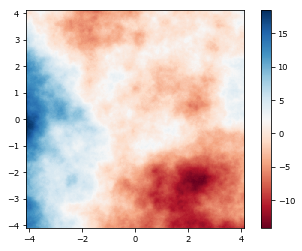

In [4]:
imshow_field(layer.phase_for(wavelength), cmap='RdBu')
plt.colorbar()
plt.show()

And we can propagate light through the atmospheric layer as usual.

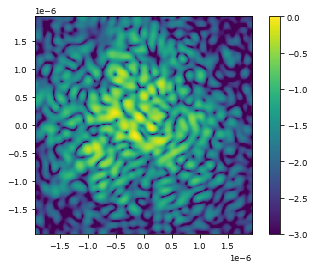

In [5]:
wf = Wavefront(aperture, wavelength)
img = prop(layer(wf))

imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-3)
plt.colorbar()
plt.show()

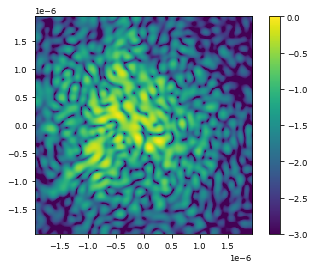

In [6]:
layer.t = 0.1 # sec

img = prop(layer(wf))

imshow_field(np.log10(img.intensity / img.intensity.max()), vmin=-3)
plt.colorbar()
plt.show()

These single layers can be combined into a multi-layer atmospheric model. Here we a standard atmospheric model, given by Guyon (2005) "Limits of Adaptive Optics for high contrast imaging". Any layer structure can be implemented. The altitude of each layer is indicated by the height parameter of the AtmosphericLayer objects themselves.

As we want to do Fresnel diffraction and avoid edge effects, we have to redefine our grids to be slightly oversized. Afterwards, we make the atmospheric layers, and add them to a multi-layer atmospheric model.

In [7]:
pupil_grid = make_pupil_grid(256, 1.5)
focal_grid = make_focal_grid(pupil_grid, 2, 64)
prop = FraunhoferPropagator(pupil_grid, focal_grid)

pup = circular_aperture(1)(pupil_grid)

# Make multi-layer atmosphere
layers = make_standard_atmospheric_layers(pupil_grid, outer_scale)

atmos = MultiLayerAtmosphere(layers, scintilation=True)

Now we can set the right seeing parameter and propagate through it to show the scintillation. To avoid edge effects during the Fresnel propagation, we use a super-Gaussian as an amplitude mask. This makes the edges of the field more continuous and therefore lessens edge effects.

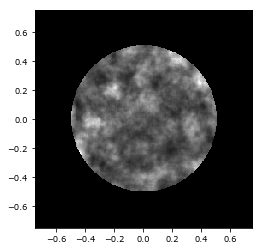

In [8]:
# Set the seeing parameters and reset
atmos.Cn_squared = Cn_squared_from_fried_parameter(0.1, 550e-9)
atmos.reset()

# Use super-Gaussian to avoid edge effects
p = np.exp(-(pupil_grid.as_('polar').r/0.68)**20)
wf = atmos(Wavefront(Field(p, pupil_grid), 2e-6))

# Show scintillation field
imshow_field(wf.intensity * pup, cmap='gray')
plt.show()